In [ ]:
import os
import cv2
import shutil
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
def check_image_extensions(base_path):
    image_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif', '.webp'}
    extensions_count = Counter()

    for folder_type in ['RECT', 'SQUARE']:
        folder_path = os.path.join(base_path, folder_type)                        

        for subdir in os.listdir(folder_path):
            subdir_path = os.path.join(folder_path, subdir)
            
            if os.path.isdir(subdir_path):    
                for file in os.listdir(subdir_path):
                    file_ext = os.path.splitext(file)[1].lower()

                    if file_ext in image_extensions:
                        extensions_count[file_ext] += 1
    
    print("Найденные расширения изображений:") # нужно для дальнейшей работы с изображениями
    for ext, count in extensions_count.items():
        print(f"  {ext}: {count} файлов")
    
    return extensions_count

base_path = r"../data/lpr_keypoints"
check_image_extensions(base_path)

Найденные расширения изображений:
  .png: 10050 файлов


Counter({'.png': 10050})

### Сохранение превью

Найдено образцов: 10050
Визуализация: 4 примеров


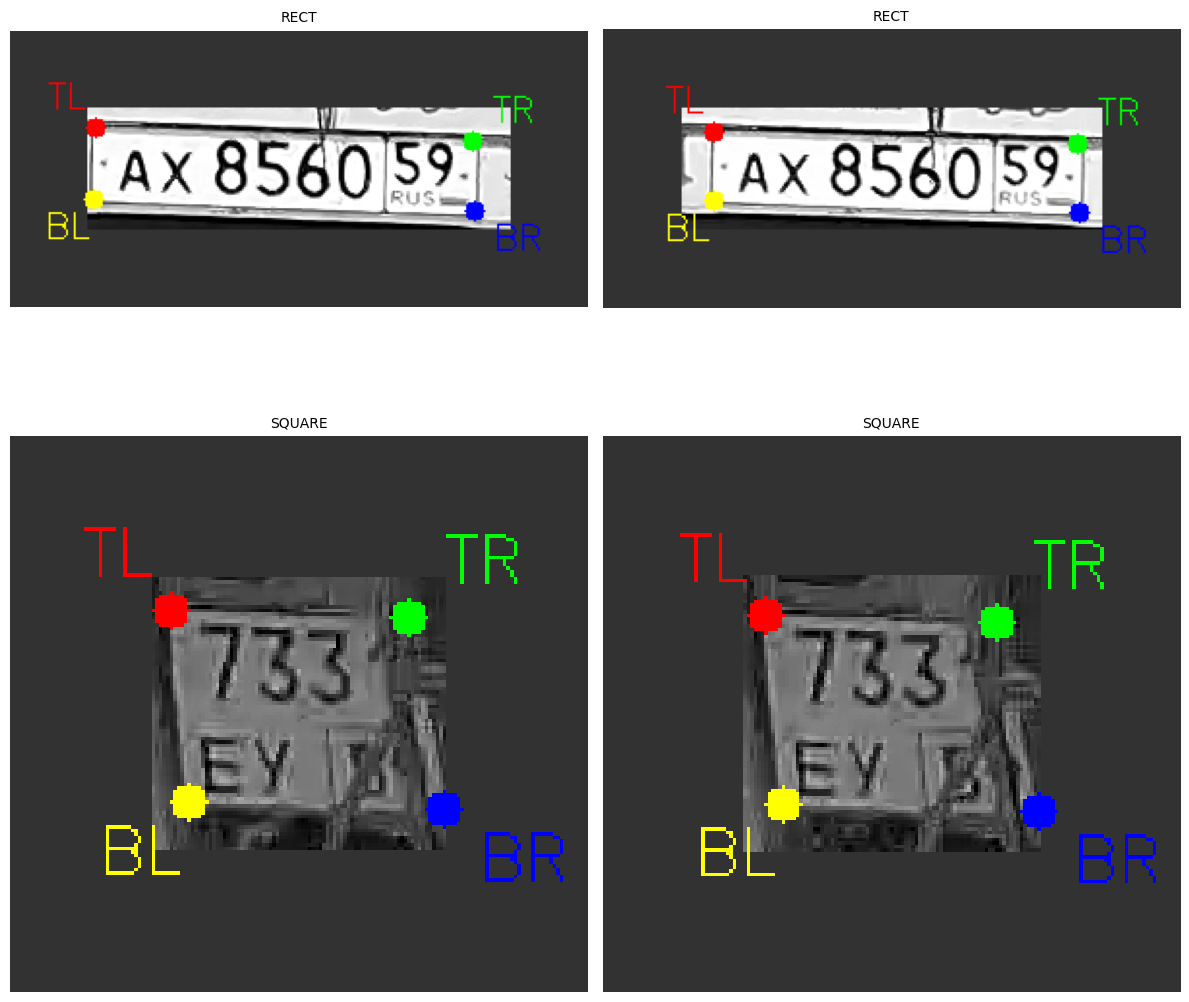


Пример координат:
TL 0.019037066881547132 0.16931216931216939
TR 0.9112208282039865 0.2769279796048437
BR 0.9138400691479609 0.8566117332847735
BL 0.01718658599404564 0.7534219551427965



In [ ]:
source_dir = Path('../data/lpr_keypoints')

samples = []
for plate_type in ['RECT', 'SQUARE']:
    type_dir = source_dir / plate_type
    if not type_dir.exists():
        continue
    
    for subfolder in type_dir.iterdir():
        if not subfolder.is_dir():
            continue
        
        for png_file in subfolder.glob('*.png'):
            txt_file = png_file.with_suffix('.txt')
            if txt_file.exists():
                samples.append({'image': png_file, 'annotation': txt_file, 'type': plate_type})

rect_samples = [s for s in samples if s['type'] == 'RECT'][:2]
square_samples = [s for s in samples if s['type'] == 'SQUARE'][:2]
preview_samples = rect_samples + square_samples

print(f"Найдено образцов: {len(samples)}")
print(f"Визуализация: {len(preview_samples)} примеров")

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, sample in enumerate(preview_samples):
    img = cv2.imread(str(sample['image']), cv2.IMREAD_GRAYSCALE)
    
    with open(sample['annotation'], 'r') as f:
        parts = f.read().strip().split()
    
    kpts = {}
    for i in range(0, len(parts), 3):
        if i + 2 < len(parts):
            kpts[parts[i]] = (float(parts[i+1]), float(parts[i+2]))
    
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    h, w = img.shape
    
    padding = 40
    img_padded = cv2.copyMakeBorder(img_color, padding, padding, padding, padding, 
                                     cv2.BORDER_CONSTANT, value=(50, 50, 50))
    
    colors = {'TL': (255, 0, 0), 'TR': (0, 255, 0), 'BR': (0, 0, 255), 'BL': (255, 255, 0)}
    for label, (x, y) in kpts.items():
        px, py = int(x * w) + padding, int(y * h) + padding
        cv2.circle(img_padded, (px, py), 5, colors[label], -1)
        
        if label == 'TL':
            text_x, text_y = px - 25, py - 10
        elif label == 'TR':
            text_x, text_y = px + 10, py - 10
        elif label == 'BR':
            text_x, text_y = px + 10, py + 20
        elif label == 'BL':
            text_x, text_y = px - 25, py + 20
        
        cv2.putText(img_padded, label, (text_x, text_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, colors[label], 1)
    
    axes[idx].imshow(img_padded)
    axes[idx].set_title(f"{sample['type']}", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('dataset_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nПример координат:")
if preview_samples:
    with open(preview_samples[0]['annotation'], 'r') as f:
        print(f.read())

### Перевод данных в формат yolo

In [ ]:
source_dir = Path('data/lpr_keypoints')
output_dir = Path('data/lpr_yolo')

samples = []
for plate_type in ['RECT', 'SQUARE']:
    type_dir = source_dir / plate_type
    if not type_dir.exists():
        continue
    
    for subfolder in type_dir.iterdir():
        if not subfolder.is_dir():
            continue
        
        for png_file in subfolder.glob('*.png'):
            txt_file = png_file.with_suffix('.txt')
            if txt_file.exists():
                samples.append({'image': png_file, 'annotation': txt_file, 'type': plate_type})

print(f"Найдено образцов: {len(samples)}")

train_samples, temp = train_test_split(samples, train_size=0.8, random_state=42)
val_samples, test_samples = train_test_split(temp, train_size=0.75, random_state=42)

print(f"Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")

for split, split_samples in [('train', train_samples), ('val', val_samples), ('test', test_samples)]:
    (output_dir / split / 'images').mkdir(parents=True, exist_ok=True)
    (output_dir / split / 'labels').mkdir(parents=True, exist_ok=True)
    
    for sample in split_samples:
        img = cv2.imread(str(sample['image']), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        h, w = img.shape
        
        with open(sample['annotation'], 'r') as f:
            parts = f.read().strip().split()
        
        kpts = {}
        for i in range(0, len(parts), 3):
            if i + 2 < len(parts):
                kpts[parts[i]] = (float(parts[i+1]), float(parts[i+2]))
        
        tl, tr, br, bl = kpts['TL'], kpts['TR'], kpts['BR'], kpts['BL']
        
        x_min = min(tl[0], tr[0], br[0], bl[0])
        x_max = max(tl[0], tr[0], br[0], bl[0])
        y_min = min(tl[1], tr[1], br[1], bl[1])
        y_max = max(tl[1], tr[1], br[1], bl[1])
        
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        
        yolo_line = f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        for pt in [tl, tr, br, bl]:
            yolo_line += f" {pt[0]:.6f} {pt[1]:.6f} 2"
        
        name = f"{sample['type']}_{sample['image'].parent.name}_{sample['image'].stem}"
        
        shutil.copy(sample['image'], output_dir / split / 'images' / f"{name}.png")
        
        with open(output_dir / split / 'labels' / f"{name}.txt", 'w') as f:
            f.write(yolo_line + '\n')

yaml_content = f"""path: {output_dir.absolute()}
train: train/images
val: val/images
test: test/images

names:
  0: license_plate

kpt_shape: [4, 3]
"""

with open(output_dir / 'lpr_keypoints.yaml', 'w') as f:
    f.write(yaml_content)

print(f"Готово: {output_dir}")

Найдено образцов: 10050
Train: 8040, Val: 1507, Test: 503
Готово: data\lpr_yolo


### Визуализация распределения классов

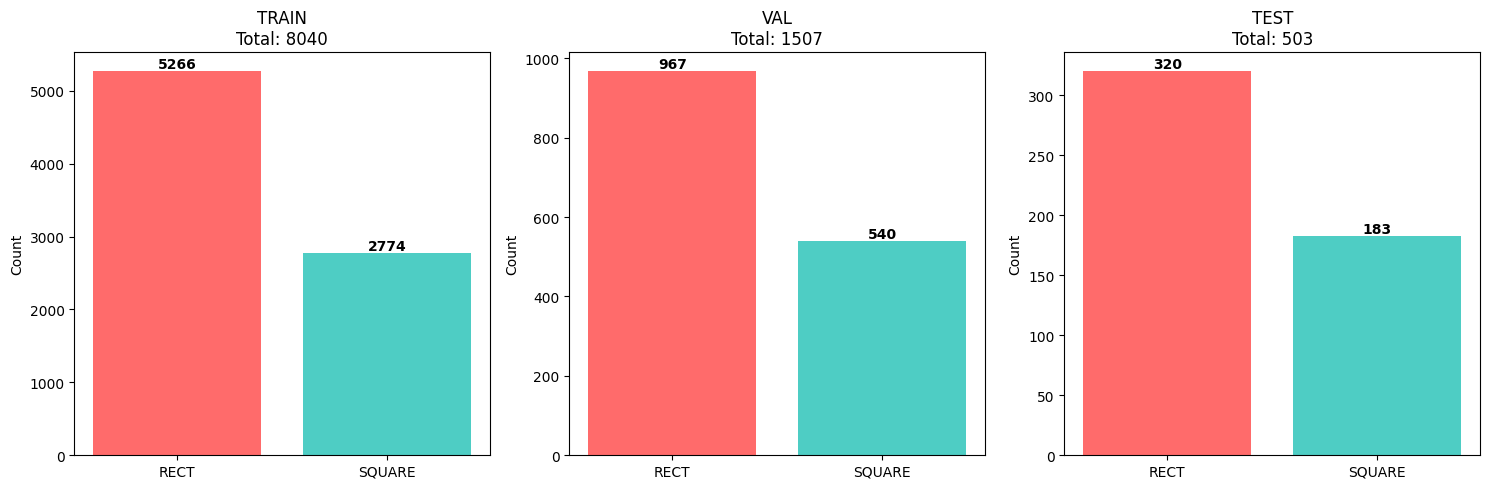

Всего: 10050 изображений


In [ ]:
output_dir = Path('data/lpr_yolo')

stats = {'train': {'RECT': 0, 'SQUARE': 0}, 
         'val': {'RECT': 0, 'SQUARE': 0}, 
         'test': {'RECT': 0, 'SQUARE': 0}}

for split in ['train', 'val', 'test']:
    images_dir = output_dir / split / 'images'
    if not images_dir.exists():
        continue
    
    for img_file in images_dir.glob('*.png'):
        plate_type = img_file.stem.split('_')[0]
        if plate_type in ['RECT', 'SQUARE']:
            stats[split][plate_type] += 1

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#FF6B6B', '#4ECDC4']

for idx, split in enumerate(['train', 'val', 'test']):
    rect_count = stats[split]['RECT']
    square_count = stats[split]['SQUARE']
    
    axes[idx].bar(['RECT', 'SQUARE'], [rect_count, square_count], color=colors)
    axes[idx].set_title(f'{split.upper()}\nTotal: {rect_count + square_count}')
    axes[idx].set_ylabel('Count')
    
    for i, count in enumerate([rect_count, square_count]):
        axes[idx].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

total = sum(stats[s]['RECT'] + stats[s]['SQUARE'] for s in ['train', 'val', 'test'])
print(f"Всего: {total} изображений")